# Creation of Siamese Network Architecture

![Image](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*I7a9aVN2poHUtiHSq2q44Q.png)


**Introduction**

A Siamese network is a class of neural networks that contains one or more identical networks. We feed a pair of inputs to these networks. Each network computes the features of one input. And, then the similarity of features is computed using their difference or the dot product. For same class input pairs, target output is 1 and for different classes input pairs, the output is 0. Both networks have same the parameters and weights. 


*Convolutional Neural Network (CNN):*

* Convolutional Neural Network (CNN, or ConvNet) are a special kind of multi-layer neural networks, designed to recognize visual patterns directly from pixel images with minimal preprocessing.
* Many different types such as VGGNet and ResNet 


**The basic archietecture for Siamese Network constitutes the following:**

* Firstly, we have our input layer. Using a CNN.

* Then, Conv2D and MaxPool layers. 

* After that, we flatten it and add a dense layer. 

* Then, when connecting these two models, we take the dot product of these features. Since we have normalized the features already, they will be between 0 and 1. 



The benefits of choosing Siamese Network:

1. Model is useful when less data is available and classes are imbalanced.
2. Suitable for classification tasks such as Image Classification


**Sources:**

1. [Siamese Network Introduction](https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee)
2. [CNN Introduction](https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) 

# Import libraries

In [68]:
import gc
import cv2
import glob
import numpy as np
import collections
import os
from keras_applications.imagenet_utils import preprocess_input
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice, sample


from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgba2rgb

C:\Users\rusta\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


#### Create function to read images into inputable format for Siamese Network

Some image formats contain 4 channels instead of 3, having an alpha channel/dimension focusing on transparency of colour as well. However as the model focuses on other attributes, such images are converted to 3 channels instead.

In [79]:
def read_img(path):
    img = cv2.imread(path)
    
    if img.shape[-1] == 4:
                img = rgba2rgb(img) #convert to 3 channels
            
    img = resize(img, (224, 224), anti_aliasing=True)
    img = np.array(img).astype(float)
    return preprocess_input(img, data_format = "channels_last", mode="caffe")

#### Indication of Main Working Folder

This folder contains folders of each family, with each family containing subfolders of unique family members.

In [31]:
main_folder = "Combined_Families"

In [32]:
#creates dictionary where key is family and values are family members in family
allPhotos = defaultdict(list)
families = []
totalphotocount = 0
# indicate name of folder housing all training image folders
for family in glob.glob(main_folder + "/*"):
    families.append(family)
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)
            totalphotocount +=1

#forms list of all families
ppl = list(allPhotos.keys())

#Counts number of members
len(ppl)

#print statement
print(f"Number of Families: {len(families)} \nNumber of unique Humans: {len(ppl)} \nAverage of {int(totalphotocount/len(ppl))} images per unique human")

Number of Families: 52 
Number of unique Humans: 214 
Average of 4 images per unique human


In [33]:
# Get first 5 items in dictionary of allPhotos, which contains all unique humans and the images within
out = collections.OrderedDict(list(allPhotos.items())[0:5])
out

OrderedDict([('Combined_Families\\F0150\\MID1',
              ['Combined_Families\\F0150\\MID1\\P01612_face3.jpg',
               'Combined_Families\\F0150\\MID1\\P01614_face2.jpg',
               'Combined_Families\\F0150\\MID1\\P01615_face3.jpg',
               'Combined_Families\\F0150\\MID1\\P01616_face2.jpg',
               'Combined_Families\\F0150\\MID1\\P01618_face3.jpg']),
             ('Combined_Families\\F0150\\MID2',
              ['Combined_Families\\F0150\\MID2\\P01612_face2.jpg',
               'Combined_Families\\F0150\\MID2\\P01614_face1.jpg',
               'Combined_Families\\F0150\\MID2\\P01615_face1.jpg',
               'Combined_Families\\F0150\\MID2\\P01616_face1.jpg']),
             ('Combined_Families\\F0150\\MID3',
              ['Combined_Families\\F0150\\MID3\\P01612_face1.jpg',
               'Combined_Families\\F0150\\MID3\\P01617_face3.jpg']),
             ('Combined_Families\\F0150\\MID4',
              ['Combined_Families\\F0150\\MID4\\P01613_face2.jpg'

In [40]:
#turning data into dataframe
data = pd.read_csv('./train_relationships_fitw.csv')
print(data.shape)
data2 = pd.read_csv('./train_relationships_local.csv')
print(data2.shape)

#concatenate both dataframes of FITW and local dataset
fitw_local_df = pd.concat([data, data2])
print(joined_df.shape)

(3598, 2)
(81, 2)
(3679, 2)


In [95]:
#precise relationships of kinship
fd = pd.read_csv('./precise_relationships/fd.csv')
fs = pd.read_csv('./precise_relationships/fs.csv')
md = pd.read_csv('./precise_relationships/md.csv')
ms = pd.read_csv('./precise_relationships/ms.csv')

all_kinship = pd.concat([fd,fs,md,ms])
precise_kins_local_df = pd.concat([all_kinship, data2])

print(f"Dataframe of all 2nd generational relationships is {all_kinship.shape}")
print(f"Dataframe of all 2nd generational with local relationships is {precise_kins_local_df.shape}")

Dataframe of all 2nd generational relationships is (3866, 2)
Dataframe of all 2nd generational with local relationships is (3947, 2)


In [41]:
# Using giant database with all kinships mixed in.
data = joined_df


data.p1 = data.p1.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p1'] = data['p1'].str.replace('/', '\\')

data.p2 = data.p2.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p2'] = data['p2'].str.replace('/', '\\')

print(data.shape)
data.tail()

(3679, 2)


,p1,p2
76,Combined_Families\L907\MID1,Combined_Families\L907\MID3
77,Combined_Families\L907\MID2,Combined_Families\L907\MID4
78,Combined_Families\L907\MID2,Combined_Families\L907\MID4
79,Combined_Families\L908\MID1,Combined_Families\L908\MID3
80,Combined_Families\L908\MID2,Combined_Families\L908\MID3


In [96]:
# Using curated database with only 2nd gen kinships mixed in.
data = precise_kins_local_df


data.p1 = data.p1.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p1'] = data['p1'].str.replace('/', '\\')

data.p2 = data.p2.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p2'] = data['p2'].str.replace('/', '\\')

#remove last \ in values


def remove_last_backslash(df):
    # Iterate over the columns in the DataFrame
    for column in df.columns:
        # Get the values in the column
        values = df[column]

        # Remove the last "\" character from each value
        values = values.str.rstrip("\\")

        # Update the DataFrame with the modified values
        df[column] = values
    
    return df

# Remove the last "\" character from all values in the DataFrame
data = remove_last_backslash(data)


print(data.shape)
data.head()

(3947, 2)


,p1,p2
0,Combined_Families\F0002\MID1,Combined_Families\F0002\MID3
1,Combined_Families\F0003\MID2,Combined_Families\F0003\MID1
2,Combined_Families\F0003\MID2,Combined_Families\F0003\MID4
3,Combined_Families\F0004\MID1,Combined_Families\F0004\MID4
4,Combined_Families\F0004\MID1,Combined_Families\F0004\MID5


In [89]:
ppl[-5:]

#ensure unique humans have exact same format as dataframe containing labels

['Combined_Families\\L907\\MID3',
 'Combined_Families\\L907\\MID4',
 'Combined_Families\\L908\\MID1',
 'Combined_Families\\L908\\MID2',
 'Combined_Families\\L908\\MID3']

In [97]:
#return rows where both images are found in folder
tdata = data[ ( (data["p1"].isin(ppl)) & (data["p2"].isin(ppl)) ) ]
tdata = [ ( x[0], x[1]  ) for x in tdata.values ]
print(f"There are {len(tdata)} rows of training pairs to train kinship model on.")
print(f"There are {3598 - len(tdata)} rows of data where either 1 or both folders not found in train-faces folder")
tdata[:5]

There are 183 rows of training pairs to train kinship model on.
There are 3415 rows of data where either 1 or both folders not found in train-faces folder


[('Combined_Families\\F0150\\MID1', 'Combined_Families\\F0150\\MID4'),
 ('Combined_Families\\F0150\\MID1', 'Combined_Families\\F0150\\MID5'),
 ('Combined_Families\\F0150\\MID1', 'Combined_Families\\F0150\\MID8'),
 ('Combined_Families\\F0285\\MID1', 'Combined_Families\\F0285\\MID5'),
 ('Combined_Families\\F0285\\MID1', 'Combined_Families\\F0285\\MID4')]

### Random Batch Selection of image pairs in dataset

This allows the neural network to be trained randomly on different images in batches

('Combined_Families\\F0811\\MID5', 'Combined_Families\\F0811\\MID7')
('Combined_Families\\F0532\\MID3', 'Combined_Families\\F0532\\MID1')


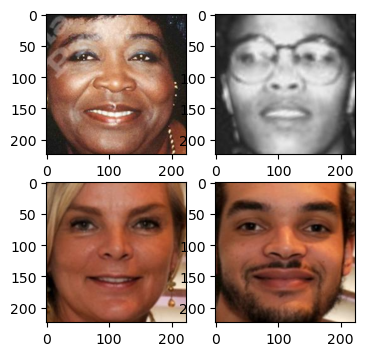

In [99]:
#EDA step, showing potential pairs within training data set
f, ax = plt.subplots(2, 2, figsize=(4, 4))
batch = sample(tdata, 2) 
for row in batch:
    print(row)
for i,j in [(0,0),(0,1),(1,0),(1,1)]:
    ax[i][j].imshow( cv2.imread( choice(allPhotos[batch[i][j]]) ) [:, :, ::-1] )

In [85]:
# This one is for FITW full dataset
#decide to break up train_relationships with 90% train dataset and validation 10% (F09)
train = [ x for x in tdata if 'F09' not in x[0]  ]
val = [ x for x in tdata if 'F09' in x[0]  ]
len(train), len(val)

(2266, 224)

In [100]:
# Split the data into a training set and a test set. 90% train dataset and validation 10% (F09)
train, val = train_test_split(tdata, test_size=0.1, random_state=42)
len(val)

19

# Development of Specific Functions

In order to ensure deep learning model runs well, 2 specific functions are created to streamline process.

1) Function 1 (getImages) has a purpose of referring to database of positive kinship relationships and to read those specific images, while having error management.

2) Function 2 (getMiniBatch) has a purpose of ensuring that the model is learning in batches and ensuring images have similar dimensions


A generator that takes these lists, dictionary and batch size is created to generate a batch of pair of images and labels to be fed as input to the model. This generator also generates pairs of images belonging to individuals that are non-kins. Each batch generated contains an equal distribution of kins and non-kins labels.

In [101]:

# Function 1: getImages
def getImages(p1, p2):
    if p1 in allPhotos and allPhotos[p1]:
        p1 = read_img(choice(allPhotos[p1]))
    else:
        # Handle the case where allPhotos[p1] is empty or p1 is not in allPhotos
        p1 = None  # You can choose an appropriate action here

    if p2 in allPhotos and allPhotos[p2]:
        p2 = read_img(choice(allPhotos[p2]))
    else:
        # Handle the case where allPhotos[p2] is empty or p2 is not in allPhotos
        p2 = None  # You can choose an appropriate action here

    return p1, p2



# Function 2: getMiniBatch
def getMiniBatch(batch_size=16, data=train):
    p1 = []
    p2 = []
    Y = []
    
    batch = sample(data, batch_size//2)
    
    for x in batch:
        _p1, _p2 = getImages(*x)
        
        if _p1 is not None and _p2 is not None:  # Check for None
            p1.append(_p1)
            p2.append(_p2)
            Y.append(1)
        
    while len(Y) < batch_size:
        _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
        
        if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
            _p1,_p2 = getImages(_p1,_p2)
            
            if _p1 is not None and _p2 is not None:  # Check for None
                p1.append(_p1)
                p2.append(_p2)
                Y.append(0)
                
    if not p1 or not p2:
        raise ValueError("No valid images found")  # Handle the case of empty lists and stops function here.
    
    # Check if all images have the same shape and dimensions
    image_shape = p1[0].shape  # Assuming the first image in the list
    for img in p1:
        if img.shape != image_shape:
            raise ValueError("Images in p1 have inconsistent shapes")

    for img in p2:
        if img.shape != image_shape:
            raise ValueError("Images in p2 have inconsistent shapes")
            
    
    # Convert p1 and p2 to NumPy arrays
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    # Convert Y to a NumPy array if it's not already
    Y = np.array(Y)
            
            
    return [p1,p2], Y


### Initialization of X and y arrays for training

In [102]:
# Initialize lists to store images, labels, and unique person IDs
X = []
y = []
person_ids = []

In [73]:
# Script to ensure that all photos are of similar dimensions
# Original
# Load and preprocess the images from the image folder
image_folder = 'Combined_Families'
count = 0
specimen = []

# Create input data (X) by loading and preprocessing the images from the image folder
for image_filename in os.listdir(image_folder):
    genetic_specimen = os.path.join(image_folder, image_filename)  #image_path is folder of each folder with images inside
    
    for indiv in os.listdir(genetic_specimen):
        
        person_path = os.path.join(genetic_specimen, indiv) 
        
        for img in os.listdir(person_path):
            
            image_path = os.path.join(person_path, img) 
            
            image = cv2.imread(image_path) #products object of type <class 'numpy.ndarray'>
            
            #if have 4 channels, which means has alpha channel
            if image.shape[-1] == 4:
                image = rgba2rgb(image) #convert to 3 channels


            image = resize(image, (224, 224), anti_aliasing=True)
            X.append(image.flatten()) #Need to flatten image
            count +=1
            specimen.append(image_filename)

print(f"There are {count} images in total")
print(f"This is the order of the photos: {specimen} ")

There are 1009 images in total
This is the order of the photos: ['F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0150', 'F0271', 'F0271', 'F0271', 'F0271', 'F0271', 'F0271', 'F0271', 'F0271', 'F0271', 'F0271', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0285', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0339', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424', 'F0424',

# Modelling

Imagenet weights has been chosen with siamese architecture that extracts and learns facial embeddings and relationships between images. This method is the quite prevalent in current literature and will be used as a prototypical model as of now.


Sources: 

- [2019 Medium Article](https://towardsdatascience.com/deep-neural-networks-for-kinship-prediction-using-face-photos-f2ad9ab53834)
- [2020 Medium Article](https://medium.com/@sritejabanisetti21/kinship-recognition-through-a-double-siamese-network-b2edacf39aee)
- [2020 Journal Article](https://www.researchgate.net/publication/341817234_Deep_Fusion_Siamese_Network_for_Automatic_Kinship_Verification)

In [74]:
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
# updated tensorflow version, which changes keras version to keras-2.14.0
from tensorflow.keras.applications import VGG16  # Or another architecture

# Choice of using pre-trained VGG16 model

VGG16 returns a 4096-dimensional feature vector for each input image, while VGG Face model gives a 2048 dimensional vector once the fully connected layers are cut down. Whereas the FaceNet model returns a 128-dimensional vector for each face.

In [135]:
IMG_DIM = (224,224,3)

vggface = VGG16(include_top=False, weights='imagenet')

for layer in vggface.layers[:-3]:
    layer.trainable=True

ValueError: The `weights` argument should be either `None` (random initialization), `imagenet` (pre-training on ImageNet), or the path to the weights file to be loaded.  Received: weights=resnet50

In [111]:
#ChatGPT improved version of above cell. 
import numpy as np
import tensorflow as tf

def initialize_bias(shape, dtype=None, name=None):
    if dtype is None:
        dtype = tf.float32  # Set the default data type to float32
    return tf.constant(np.random.normal(loc=0.5, scale=1e-2, size=shape), dtype=dtype, name=name)

def initialize_weights(shape, dtype=None, name=None):
    if dtype is None:
        dtype = tf.float32  # Set the default data type to float32
    return tf.constant(np.random.normal(loc=0.0, scale=1e-2, size=shape), dtype=dtype, name=name)


### Version 1: Implementation of Siamese Network Architecture (Version 1 with adapted AUC measure)

![Image](https://miro.medium.com/v2/resize:fit:828/format:webp/1*r_B3uuBzcQPB7jOseqfxpA.jpeg)



The outputs from these models are passed through several other layers of the model and at last, a fully connected layer with a sigmoid function in the end, returns the probability score. 

In [108]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    #if len(np.unique(y_true)) == 1:
    #    return 0.5  # or any other appropriate value, contains predefined value of 0.5
    if tf.shape(y_true)[0] > 1:  
        
        auc_value = tf.py_function(lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr'),
                                   (y_true, y_pred), tf.float32)
        
        return auc_value
    else:
        return 0.5  # or any other appropriate value
    
    #return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.1)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

#compilation step, removed auc and only put accuracy
siamese_net.compile(loss="binary_crossentropy",optimizer= 'adam',metrics=['accuracy', auc]) #If needed, can put accuracy here

In [109]:
# This is for precise_relationships folder, with fd,fs,md,ms.
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

batch_size = 16

def data_generator(data, batch_size):
    while True:
        batch_data = getMiniBatch(batch_size=batch_size, data=data)
        yield batch_data

train_gen = data_generator(train, batch_size)
val_gen = data_generator(val, batch_size)

history = siamese_net.fit(train_gen, steps_per_epoch=200, epochs=20, #Changed from 100 to 20
                          validation_data=val_gen, validation_steps=100,
                          verbose=1, callbacks=callbacks_list)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.5041 - auc: 0.4932 
Epoch 1: val_auc improved from -inf to 0.50000, saving model to model_best_checkpoint.h5
200/200 [==============================] - 2717s 14s/step - loss: 0.7051 - accuracy: 0.5041 - auc: 0.4932 - val_loss: 0.6947 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.4959 - auc: 0.4923
Epoch 2: val_auc did not improve from 0.50000
200/200 [==============================] - 2153s 11s/step - loss: 0.6985 - accuracy: 0.4959 - auc: 0.4923 - val_loss: 0.6949 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.4919 - auc: 0.4907
Epoch 3: val_auc did not improve from 0.50000
200/200 [==============================] - 2010s 10s/step - loss: 0.6983 - accuracy: 0.4919 - auc: 0.4907 - val_loss: 0.6952 - val

KeyboardInterrupt: 

## Version 2: Siamese Network Architecture with Smaller Dataset, using Asian-only Faces

In [82]:
# This is for FITW Combined Families using FITW_relationships.csv
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

batch_size = 16

def data_generator(data, batch_size):
    while True:
        batch_data = getMiniBatch(batch_size=batch_size, data=data)
        yield batch_data

train_gen = data_generator(train, batch_size)
val_gen = data_generator(val, batch_size)

history = siamese_net.fit(train_gen, steps_per_epoch=200, epochs=20, #Changed from 100 to 50
                          validation_data=val_gen, validation_steps=100,
                          verbose=1, callbacks=callbacks_list)

Epoch 1/5
200/200 [==============================] - 2104s 10s/step - loss: 4.9143 - accuracy: 0.5056 - val_loss: 0.6968 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - 2494s 12s/step - loss: 0.7021 - accuracy: 0.5038 - val_loss: 0.6969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - 2365s 12s/step - loss: 0.6998 - accuracy: 0.5031 - val_loss: 0.6967 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - 1988s 10s/step - loss: 0.6968 - accuracy: 0.5194 - val_loss: 0.6969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/5
200/200 [==============================] - 21043s 106s/step - loss: 0.7015 - accuracy: 0.4975 - val_loss: 0.6967 - val_accuracy: 0.5000 - lr: 0.0010


In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

batch_size = 16

def data_generator(data, batch_size):
    while True:
        batch_data = getMiniBatch(batch_size=batch_size, data=data)
        yield batch_data

train_gen = data_generator(train, batch_size)
val_gen = data_generator(val, batch_size)

history = siamese_net.fit(train_gen, steps_per_epoch=200, epochs=20, #Changed from 100 to 50
                          validation_data=val_gen, validation_steps=100,
                          verbose=1, callbacks=callbacks_list)

In [96]:
# Evaluate the model on the training and validation sets from Merlion Code
train_accuracy = siamese_net.evaluate(train_gen)[1]
test_accuracy = siamese_net.evaluate(validation_gen)[1]

print("Train accuracy:", train_accuracy)
print("Validation accuracy:", test_accuracy)

    374/Unknown - 718s 2s/step - loss: 0.7070 - accuracy: 0.5027

KeyboardInterrupt: 

###  Metrics for Performance of Siamese Network

Using Accuracy and Loss Value

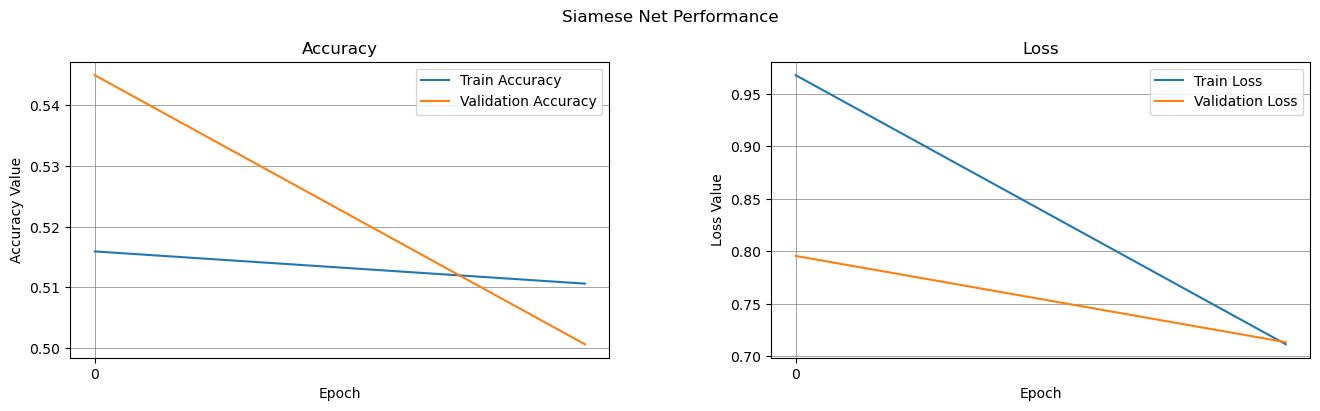

In [97]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)


### Saving of Model Weights in .h5 file for loading in deployment

In [ ]:
#manually saving weights in Siamese Network
# Save the weights, by default saves with .ckpt extension
siamese_net.save_weights('./checkpoints/my_checkpoint_v1')


In [ ]:
#saving best model in .keras format. Newest format
siamese_net.save('best_model6nov.keras')

In [ ]:
#Saving best model in .h5 format
siamese_net.save('best_model6nov.h5', save_format='h5')

In [ ]:
siamese_net.load_weights('best_model6nov.h5')

# Version 3: Alteration of AUC function to get a better outcome

This is due to the fact that the val_auc has been constant and does not see improvement with epochs. 

In [112]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.1)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

#compilation step, removed auc and only put accuracy
siamese_net.compile(loss="binary_crossentropy",optimizer= 'adam',metrics=['accuracy', auc]) #If needed, can put accuracy here

In [113]:
# This is for precise_relationships and local families combined.
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

batch_size = 16

def data_generator(data, batch_size):
    while True:
        batch_data = getMiniBatch(batch_size=batch_size, data=data)
        yield batch_data

train_gen = data_generator(train, batch_size)
val_gen = data_generator(val, batch_size)

history = siamese_net.fit(train_gen, steps_per_epoch=200, epochs=20, #Changed from 100 to 50
                          validation_data=val_gen, validation_steps=100,
                          verbose=1, callbacks=callbacks_list)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.5000 - auc: 0.4974 
Epoch 1: val_auc improved from -inf to 0.50000, saving model to model_best_checkpoint.h5
200/200 [==============================] - 2684s 13s/step - loss: 1.3726 - accuracy: 0.5000 - auc: 0.4974 - val_loss: 0.6958 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5219 - auc: 0.5201 
Epoch 2: val_auc did not improve from 0.50000
200/200 [==============================] - 2536s 13s/step - loss: 0.6974 - accuracy: 0.5219 - auc: 0.5201 - val_loss: 0.6959 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.4953 - auc: 0.4908
Epoch 3: val_auc did not improve from 0.50000
200/200 [==============================] - 1975s 10s/step - loss: 0.7009 - accuracy: 0.4953 - auc: 0.4908 - val_loss: 0.6957 - va

KeyboardInterrupt: 

# Version 4: Usage of all FITW 1st Generation Kinship Relationships

This is to ensure larger sample size and higher accuracy.

In [157]:
#train-faces contains only FITW dataset
main_folder = "train-faces"

In [158]:
#creates dictionary where key is family and values are family members in family
allPhotos = defaultdict(list)
families = []
totalphotocount = 0
# indicate name of folder housing all training image folders
for family in glob.glob(main_folder + "/*"):
    families.append(family)
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)
            totalphotocount +=1

#forms list of all families
ppl = list(allPhotos.keys())

#Counts number of members
len(ppl)

#print statement
print(f"Number of Families: {len(families)} \nNumber of unique Humans: {len(ppl)} \nAverage of {int(totalphotocount/len(ppl))} images per unique human")

Number of Families: 800 
Number of unique Humans: 3949 
Average of 5 images per unique human


In [146]:
# Get first 2 and last 2 in dictionary of allPhotos, which contains all unique humans and the images within
first = collections.OrderedDict(list(allPhotos.items())[0:2])
print(first)
last = collections.OrderedDict(list(allPhotos.items())[-2:])
print("")
print(last)

OrderedDict([('train-faces\\F0001\\MID1', ['train-faces\\F0001\\MID1\\P00001_face2.jpg', 'train-faces\\F0001\\MID1\\P00002_face3.jpg', 'train-faces\\F0001\\MID1\\P00003_face1.jpg', 'train-faces\\F0001\\MID1\\P00004_face3.jpg', 'train-faces\\F0001\\MID1\\P00007_face2.jpg', 'train-faces\\F0001\\MID1\\P00008_face7.jpg']), ('train-faces\\F0001\\MID2', ['train-faces\\F0001\\MID2\\P00001_face1.jpg', 'train-faces\\F0001\\MID2\\P00002_face2.jpg', 'train-faces\\F0001\\MID2\\P00003_face2.jpg', 'train-faces\\F0001\\MID2\\P00004_face1.jpg', 'train-faces\\F0001\\MID2\\P00008_face2.jpg'])])

OrderedDict([('train-faces\\L908\\MID2', ['train-faces\\L908\\MID2\\img1.jpg', 'train-faces\\L908\\MID2\\img2.jpeg']), ('train-faces\\L908\\MID3', ['train-faces\\L908\\MID3\\img1.jpg'])])


In [123]:
#turning data into dataframe
data2 = pd.read_csv('./train_relationships_local.csv')
print(data2.shape)

(81, 2)


In [124]:
#precise relationships of FITW dataset kinship
fd = pd.read_csv('./precise_relationships/fd.csv')
fs = pd.read_csv('./precise_relationships/fs.csv')
md = pd.read_csv('./precise_relationships/md.csv')
ms = pd.read_csv('./precise_relationships/ms.csv')

all_kinship = pd.concat([fd,fs,md,ms])
precise_kins_local_df = pd.concat([all_kinship, data2])

# total number of 2nd gen relationships
print(f"Dataframe of all 2nd generational relationships is {all_kinship.shape}")

Dataframe of all 2nd generational relationships is (3866, 2)


In [152]:
# Using curated database with only 2nd gen kinships mixed in.
data = joined_df


data.p1 = data.p1.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p1'] = data['p1'].str.replace('/', '\\')

data.p2 = data.p2.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p2'] = data['p2'].str.replace('/', '\\')

#remove last \ in values


def remove_last_backslash(df):
    # Iterate over the columns in the DataFrame
    for column in df.columns:
        # Get the values in the column
        values = df[column]

        # Remove the last "\" character from each value
        values = values.str.rstrip("\\")

        # Update the DataFrame with the modified values
        df[column] = values
    
    return df

# Remove the last "\" character from all values in the DataFrame
data = remove_last_backslash(data)


print(data.shape)
data.head()

(3679, 2)


,p1,p2
0,train-faces\train-faces\Combined_Families\F000...,train-faces\train-faces\Combined_Families\F000...
1,train-faces\train-faces\Combined_Families\F000...,train-faces\train-faces\Combined_Families\F000...
2,train-faces\train-faces\Combined_Families\F000...,train-faces\train-faces\Combined_Families\F000...
3,train-faces\train-faces\Combined_Families\F000...,train-faces\train-faces\Combined_Families\F000...
4,train-faces\train-faces\Combined_Families\F000...,train-faces\train-faces\Combined_Families\F000...


In [126]:
ppl[-5:]

['train-faces\\L907\\MID3',
 'train-faces\\L907\\MID4',
 'train-faces\\L908\\MID1',
 'train-faces\\L908\\MID2',
 'train-faces\\L908\\MID3']

In [128]:
#return rows where both images are found in folder
tdata = data[ ( (data["p1"].isin(ppl)) & (data["p2"].isin(ppl)) ) ]
tdata = [ ( x[0], x[1]  ) for x in tdata.values ]
print(f"There are {len(tdata)} rows of training pairs to train kinship model on.")
print(f"There are {data.shape[0] - len(tdata)} rows of data where either 1 or both folders not found in train-faces folder")
tdata[:5]

There are 3843 rows of training pairs to train kinship model on.
There are 104 rows of data where either 1 or both folders not found in train-faces folder


[('train-faces\\F0002\\MID1', 'train-faces\\F0002\\MID3'),
 ('train-faces\\F0003\\MID2', 'train-faces\\F0003\\MID1'),
 ('train-faces\\F0003\\MID2', 'train-faces\\F0003\\MID4'),
 ('train-faces\\F0004\\MID1', 'train-faces\\F0004\\MID4'),
 ('train-faces\\F0004\\MID1', 'train-faces\\F0004\\MID5')]

In [129]:
# Split the data into a training set and a test set. 90% train dataset and validation 10% (F09)
train, val = train_test_split(tdata, test_size=0.1, random_state=42)
print(len(train))
print(len(val))

3458
385


In [130]:
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
# updated tensorflow version, which changes keras version to keras-2.14.0
from tensorflow.keras.applications import VGG16  # Or another architecture

In [131]:
IMG_DIM = (224,224,3)

vggface = VGG16(include_top=False, weights='imagenet')

for layer in vggface.layers[:-3]:
    layer.trainable=True

In [132]:
#ChatGPT improved version of above cell. 
import numpy as np
import tensorflow as tf

def initialize_bias(shape, dtype=None, name=None):
    if dtype is None:
        dtype = tf.float32  # Set the default data type to float32
    return tf.constant(np.random.normal(loc=0.5, scale=1e-2, size=shape), dtype=dtype, name=name)

def initialize_weights(shape, dtype=None, name=None):
    if dtype is None:
        dtype = tf.float32  # Set the default data type to float32
    return tf.constant(np.random.normal(loc=0.0, scale=1e-2, size=shape), dtype=dtype, name=name)


# Creating the Siamese Neural Network Architecture

The following code definesa Siamese neural network using the Keras library for image similarity comparison. The Siamese network is a type of neural network architecture designed to learn and compare similarity between pairs of inputs. In this case, it appears is used for a binary classification tasks (e.g., determining if two faces provided are 1st degree kin).

The code follows the following steps:

1. Defines a custom AUC (Area Under the Curve) metric function, auc, which computes the ROC AUC score. This function is used for evaluation during model training.

2. Creates two input layers, left_input and right_input, which are placeholders for the left and right images to be compared. IMG_DIM is assumed to be the input shape of your images.

3. Passes both inputs through a VGGFace model (not shown in the code) to extract image features.

4. Concatenates the features from each image, including Global Max Pooling and Global Average Pooling, to create feature vectors x1 and x2.

5. Applies a shared fully connected (Dense) layer with ReLU activation, kernel regularization, and custom weight initialization to each feature vector.

6. Computes various operations on the feature vectors:

7. Calculations
* x3 calculates the absolute difference between the two feature vectors.
* x4 calculates the squared difference between the two feature vectors.
* x5 multiplies the two feature vectors element-wise.

8. Concatenates the results of the operations to create a single vector x.

9. Applies another fully connected layer with ReLU activation and dropout for regularization.

10. The final output layer with a sigmoid activation is used to produce a binary classification prediction, which indicates whether the two input facial images provided are 1st degree kin.

In [133]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    #if len(np.unique(y_true)) == 1:
    #    return 0.5  # or any other appropriate value, contains predefined value of 0.5
    if tf.shape(y_true)[0] > 1:  
        
        auc_value = tf.py_function(lambda y_true, y_pred: roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr'),
                                   (y_true, y_pred), tf.float32)
        
        return auc_value
    else:
        return 0.5  # or any other appropriate value
    
    #return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.1)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

#compilation step, removed auc and only put accuracy
siamese_net.compile(loss="binary_crossentropy",optimizer= 'adam',metrics=['accuracy', auc]) #If needed, can put accuracy here

In [134]:
# This is for FITW families only 1st degree kinship entire dataset + local families
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

batch_size = 16

def data_generator(data, batch_size):
    while True:
        batch_data = getMiniBatch(batch_size=batch_size, data=data)
        yield batch_data

train_gen = data_generator(train, batch_size)
val_gen = data_generator(val, batch_size)

history = siamese_net.fit(train_gen, steps_per_epoch=200, epochs=20, #Changed from 100 to 20
                          validation_data=val_gen, validation_steps=100,
                          verbose=1, callbacks=callbacks_list)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 26.2359 - accuracy: 0.5044 - auc: 0.5080
Epoch 1: val_auc improved from -inf to 0.50273, saving model to model_best_checkpoint.h5
200/200 [==============================] - 2018s 10s/step - loss: 26.2359 - accuracy: 0.5044 - auc: 0.5080 - val_loss: 0.6964 - val_accuracy: 0.5000 - val_auc: 0.5027 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.5006 - auc: 0.5001 
Epoch 2: val_auc did not improve from 0.50273
200/200 [==============================] - 2693s 13s/step - loss: 0.7036 - accuracy: 0.5006 - auc: 0.5001 - val_loss: 0.6966 - val_accuracy: 0.5000 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.4881 - auc: 0.4877 
Epoch 3: val_auc did not improve from 0.50273
200/200 [==============================] - 2600s 13s/step - loss: 0.7019 - accuracy: 0.4881 - auc: 0.4877 - val_loss: 0.6967 - 

# Version 5: Modelling all relationships of 1st generation in FITW and local datasets

In [166]:
#turning data into dataframe
data = pd.read_csv('./train_relationships_fitw.csv')
print(data.shape)
data2 = pd.read_csv('./train_relationships_local.csv')
print(data2.shape)

#concatenate both dataframes of FITW and local dataset
fitw_local_df = pd.concat([data, data2])
print(fitw_local_df.shape)
print(fitw_local_df.head())

(3598, 2)
(101, 2)
(3699, 2)
           p1          p2
0  F0002/MID1  F0002/MID3
1  F0002/MID2  F0002/MID3
2  F0005/MID1  F0005/MID2
3  F0005/MID3  F0005/MID2
4  F0009/MID1  F0009/MID4


In [167]:
# Using curated database with only 2nd gen kinships mixed in.
data = fitw_local_df


data.p1 = data.p1.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p1'] = data['p1'].str.replace('/', '\\')

data.p2 = data.p2.apply( lambda x: main_folder + '/'+x )

# Replace forward slashes in the 'p1' column with backslashes
data['p2'] = data['p2'].str.replace('/', '\\')

#remove last \ in values


def remove_last_backslash(df):
    # Iterate over the columns in the DataFrame
    for column in df.columns:
        # Get the values in the column
        values = df[column]

        # Remove the last "\" character from each value
        values = values.str.rstrip("\\")

        # Update the DataFrame with the modified values
        df[column] = values
    
    return df

# Remove the last "\" character from all values in the DataFrame
data = remove_last_backslash(data)


print(data.shape)
data.head()

(3699, 2)


,p1,p2
0,train-faces\F0002\MID1,train-faces\F0002\MID3
1,train-faces\F0002\MID2,train-faces\F0002\MID3
2,train-faces\F0005\MID1,train-faces\F0005\MID2
3,train-faces\F0005\MID3,train-faces\F0005\MID2
4,train-faces\F0009\MID1,train-faces\F0009\MID4


In [156]:
ppl[:5]

['train-faces\\F0001\\MID1',
 'train-faces\\F0001\\MID2',
 'train-faces\\F0001\\MID3',
 'train-faces\\F0001\\MID4',
 'train-faces\\F0002\\MID1']

In [168]:
#return rows where both images are found in folder
tdata = data[ ( (data["p1"].isin(ppl)) & (data["p2"].isin(ppl)) ) ]
tdata = [ ( x[0], x[1]  ) for x in tdata.values ]
print(f"There are {len(tdata)} rows of training pairs to train kinship model on.")
print(f"There are {data.shape[0] - len(tdata)} rows of data where either 1 or both folders not found in train-faces folder")
tdata[:5]

There are 2591 rows of training pairs to train kinship model on.
There are 1108 rows of data where either 1 or both folders not found in train-faces folder


[('train-faces\\F0002\\MID1', 'train-faces\\F0002\\MID3'),
 ('train-faces\\F0002\\MID2', 'train-faces\\F0002\\MID3'),
 ('train-faces\\F0005\\MID1', 'train-faces\\F0005\\MID2'),
 ('train-faces\\F0005\\MID3', 'train-faces\\F0005\\MID2'),
 ('train-faces\\F0016\\MID1', 'train-faces\\F0016\\MID5')]

In [169]:
# Split the data into a training set and a test set. 90% train dataset and validation 10% (F09)
train, val = train_test_split(tdata, test_size=0.1, random_state=42)
print(len(train))
print(len(val))

2331
260


In [170]:
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
# updated tensorflow version, which changes keras version to keras-2.14.0
from tensorflow.keras.applications import VGG16  # Or another architecture

In [171]:
IMG_DIM = (224,224,3)

vggface = VGG16(include_top=False, weights='imagenet', classifier_activation = "softmax")

for layer in vggface.layers[:-3]:
    layer.trainable=True

In [172]:
#ChatGPT improved version of above cell. 
import numpy as np
import tensorflow as tf

def initialize_bias(shape, dtype=None, name=None):
    if dtype is None:
        dtype = tf.float32  # Set the default data type to float32
    return tf.constant(np.random.normal(loc=0.5, scale=1e-2, size=shape), dtype=dtype, name=name)

def initialize_weights(shape, dtype=None, name=None):
    if dtype is None:
        dtype = tf.float32  # Set the default data type to float32
    return tf.constant(np.random.normal(loc=0.0, scale=1e-2, size=shape), dtype=dtype, name=name)

In [173]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.1)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

#compilation step, removed auc and only put accuracy
siamese_net.compile(loss="binary_crossentropy",optimizer= 'adam',metrics=['accuracy', auc]) #If needed, can put accuracy here

In [ ]:
# Save the model architecture to a file
model_architecture = siamese_net.to_json()  # Or siamese_net.to_yaml()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_architecture)

In [174]:
# This is for FITW families only 1st degree kinship entire dataset + local families
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

model_checkpoint = ModelCheckpoint('model_best_checkpoint_9nov.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=20, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

batch_size = 16

def data_generator(data, batch_size):
    while True:
        batch_data = getMiniBatch(batch_size=batch_size, data=data)
        yield batch_data

train_gen = data_generator(train, batch_size)
val_gen = data_generator(val, batch_size)

history = siamese_net.fit(train_gen, steps_per_epoch=200, epochs=20, #Changed from 100 to 20
                          validation_data=val_gen, validation_steps=100,
                          verbose=1, callbacks=callbacks_list)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.8621 - accuracy: 0.5153 - auc: 0.5077 
Epoch 1: val_auc improved from -inf to 0.51258, saving model to model_best_checkpoint_9nov.h5
200/200 [==============================] - 2404s 12s/step - loss: 0.8621 - accuracy: 0.5153 - auc: 0.5077 - val_loss: 0.6968 - val_accuracy: 0.5000 - val_auc: 0.5126 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.4919 - auc: 0.4907
Epoch 2: val_auc improved from 0.51258 to 0.52797, saving model to model_best_checkpoint_9nov.h5
200/200 [==============================] - 1969s 10s/step - loss: 0.7365 - accuracy: 0.4919 - auc: 0.4907 - val_loss: 0.6995 - val_accuracy: 0.5000 - val_auc: 0.5280 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.5044 - auc: 0.5123
Epoch 3: val_auc did not improve from 0.52797
200/200 [==============================] - 2011s 10s/step - loss: 0.7025 -

## Measuring Performance of Version 5 Siamese Network Architecture using VGG16 and AUC function

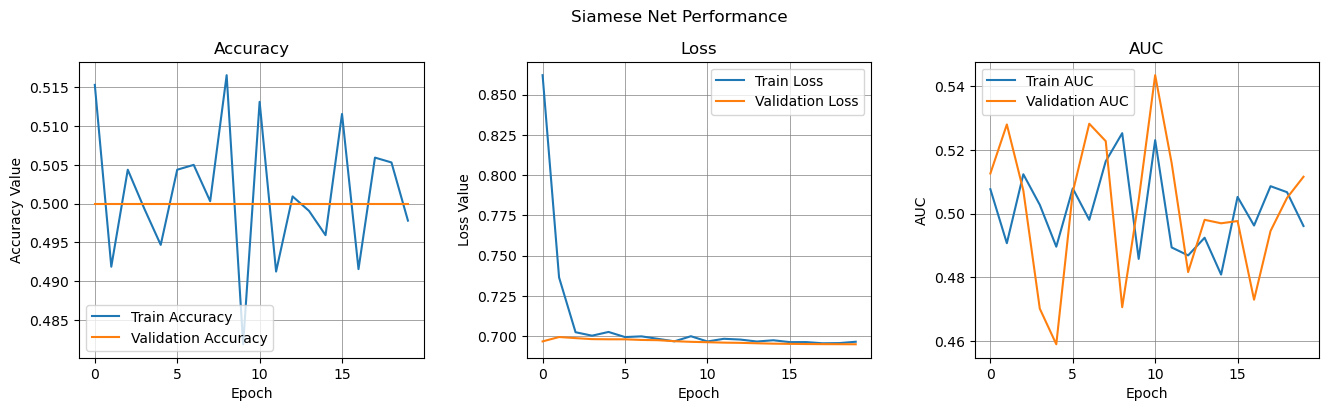

In [177]:
# Measurement of Performance
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)